# Per-pointing continuum identification?

This notebook explores whether per-pointing continuum identification is needed for the W51-E B6 data set

In [1]:
from casatools import ms, table, msmetadata
ms = ms()
tb = table()
msmd = msmetadata()

In [2]:
%matplotlib inline
import pylab as pl
pl.style.use('dark_background')

In [3]:
cd /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L


In [4]:
spw = 0
msname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibrated/uid___A002_Xcc10e0_X6dd3_W51-E_B6_spw{spw}.split')
msmd.open(msname)
fields = msmd.fieldnames()
msmd.close()
print(fields)

['W51-E', 'W51-E', 'W51-E', 'W51-E', 'W51-E', 'W51-E', 'W51-E', 'W51-E', 'W51-E', 'W51-E', 'W51-E']


In [5]:
def findcont(spectrum):
    from astropy import stats
    clipped = stats.sigma_clip(spectrum, sigma=1.8, stdfunc=stats.mad_std)
    return clipped

## We examine UV spectra in three different ways

First is the mean over time and baseline (which is probably the best)

/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Amplitude')

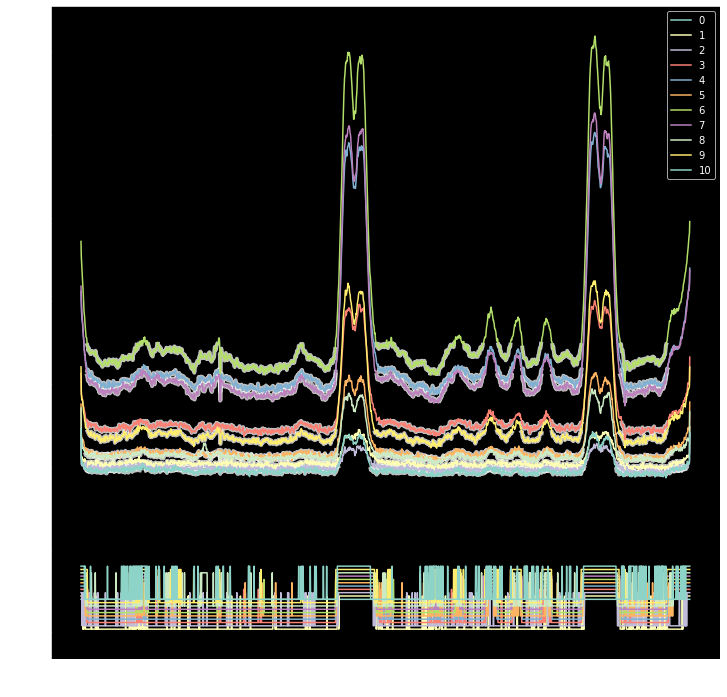

In [6]:
pl.figure(figsize=(12,12))
for field in range(len(fields)):
    msname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibrated/uid___A002_Xcc10e0_X6dd3_W51-E_B6_spw{spw}.split')
    ms.open(msname)
    ms.selectinit(reset=True)
    assert ms.select(items={'field_id': field})
    dat = ms.getdata(['model_data', 'data', 'flag', 'corrected_data',
                      'time', 'antenna1', 'antenna2', 'axis_info',
                      'uvdist', 'weight', 'scan_number'])
    assert 'data' in dat
    ms.close()
    
    toplot = np.abs(dat['data'])
    toplot[dat['flag']] = np.nan
    meanspec = np.nanmean(toplot, axis=(0,2))
    L,=pl.plot(meanspec, label=str(field))
    contspec = findcont(meanspec)
    pl.plot(contspec, color='w', zorder=-5, linewidth=4, alpha=0.75)
    pl.plot(contspec.mask+0.1*field, color=L.get_color())
pl.legend(loc='best')
pl.xlabel("Spectral Channel")
pl.ylabel("Amplitude")

Next is the median over time and baseline.    It looks fine, but it apparently emphasizes the spectral lines

/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Text(0, 0.5, 'Amplitude')

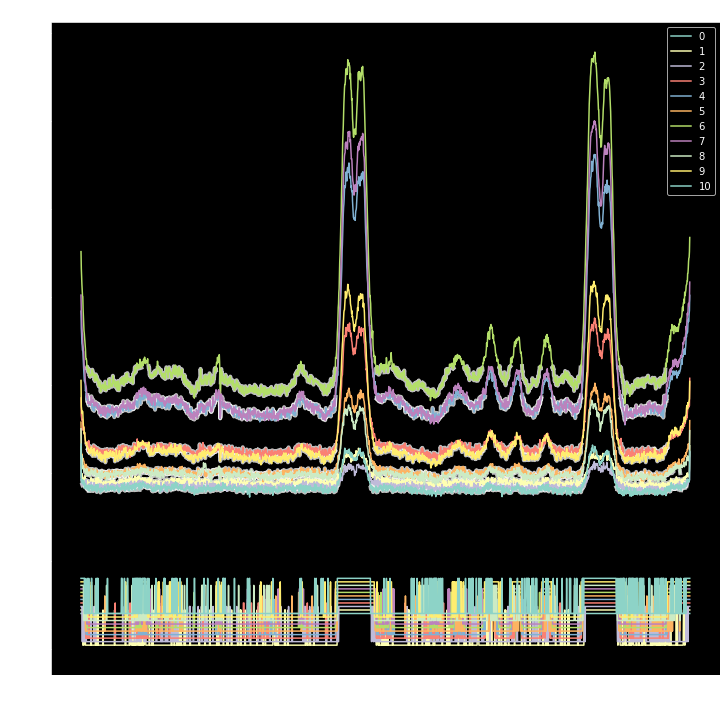

In [11]:
pl.figure(figsize=(12,12))
pl.title('median')
for field in range(len(fields)):
    ms.open(msname)
    ms.selectinit(reset=True)
    ms.select(items={'field_id':field})
    dat = ms.getdata(['model_data', 'data', 'flag', 'corrected_data', 'time', 'antenna1', 'antenna2', 'axis_info', 'uvdist', 'weight', 'scan_number'])

    toplot = np.abs(dat['data'])
    toplot[dat['flag']] = np.nan
    meanspec = np.nanmedian(toplot, axis=(0,2))
    L, = pl.plot(meanspec, label=str(field))

    contspec = findcont(meanspec)

    pl.plot(contspec, color='w', zorder=-5, linewidth=4, alpha=0.75)
    pl.plot(contspec.mask+0.1*field, color=L.get_color())

    
pl.legend(loc='best')
pl.xlabel("Spectral Channel")
pl.ylabel("Amplitude")

Last is the max (peak per frequency) spectrum, which is too noisy

/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Amplitude')

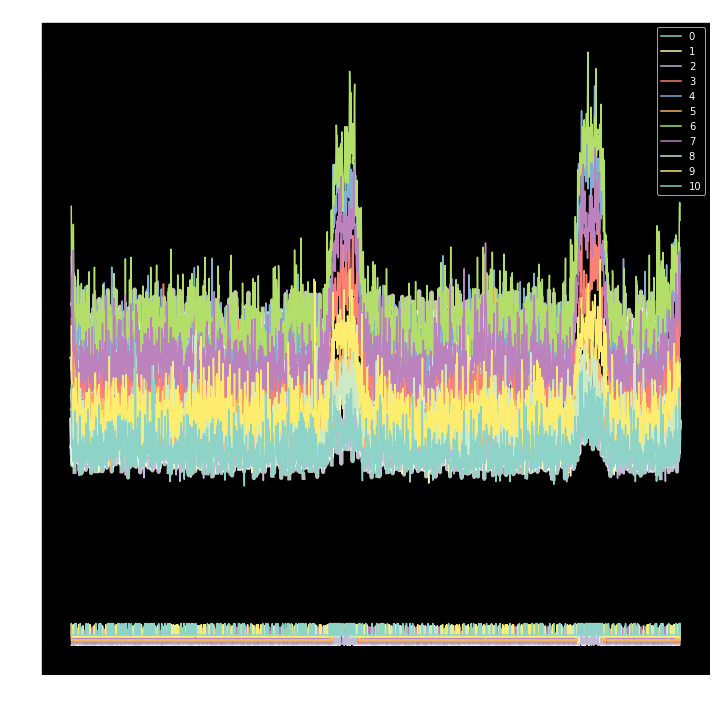

In [12]:
pl.figure(figsize=(12,12))
pl.title('max')
for field in range(len(fields)):
    ms.selectinit(reset=True)
    ms.select(items={'field_id':field})
    dat = ms.getdata(['model_data', 'data', 'flag', 'corrected_data', 'time', 'antenna1', 'antenna2', 'axis_info', 'uvdist', 'weight', 'scan_number'])

    toplot = np.abs(dat['data'])
    toplot[dat['flag']] = np.nan
    meanspec = np.nanmax(toplot, axis=(0,2))
    L, = pl.plot(meanspec, label=str(field), zorder=5+field)

    contspec = findcont(meanspec)

    pl.plot(contspec, color='w', zorder=-5, linewidth=4, alpha=0.75)
    pl.plot(contspec.mask+0.1*field, color=L.get_color())

pl.legend(loc='best')
pl.xlabel("Spectral Channel")
pl.ylabel("Amplitude")

In [13]:
contdatname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibration/cont.dat')
%run /orange/adamginsburg/ALMA_IMF/reduction/reduction/parse_contdotdat.py
contdat = parse_contdotdat(contdatname)
print(contdat)
from astropy import units as u
msmd.open(msname)
freqs = msmd.chanfreqs(0)*u.Hz
msmd.close()
sel = np.zeros(freqs.size)
for freqrange in contdat.split(";"):
    low,high = freqrange.split("~")
    high = u.Quantity(high)
    low = u.Quantity(low, unit=high.unit)
    assert high > low
    sel += (freqs > low) & (freqs < high)
    #print(f"{field}_{spw}: {low}-{high} count={sel.sum()}")

219.472514057~219.501948236GHz;219.53602349~219.581579294GHz;230.296724861~230.299654912GHz;230.556522669~230.606333527GHz;230.652237651~230.670794638GHz;230.714745395~230.734279065GHz;219.843480161~219.858380468GHz;219.875479181~219.889158151GHz;219.923355578~219.935813211GHz;219.959507142~219.96610236GHz;218.071524587~218.081536681GHz;218.090816184~218.115968519GHz;218.125125923~218.153819121GHz;218.162121833~218.169936151GHz;218.191181328~218.23367168GHz;218.246003651~218.251009698GHz;218.263097471~218.270423394GHz;218.298383999~218.31450103GHz;216.044914055~216.062496231GHz;216.081665688~216.092654548GHz;216.097050092~216.103399212GHz;216.120737191~216.128307295GHz;216.13184815~216.16176227GHz;216.182274809~216.232213075GHz;216.236608619~216.281907143GHz;216.986105808~216.997583074GHz;217.009792931~217.014432677GHz;217.022979577~217.02444476GHz;217.035922026~217.047399292GHz;217.080121709~217.14336877GHz;217.158508993~217.187812651GHz;217.206371634~217.217116308GHz;217.227128391~21

<Figure size 432x288 with 0 Axes>

The following plots inspect each spectral window and each pointing for one of the 7m data sets

/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


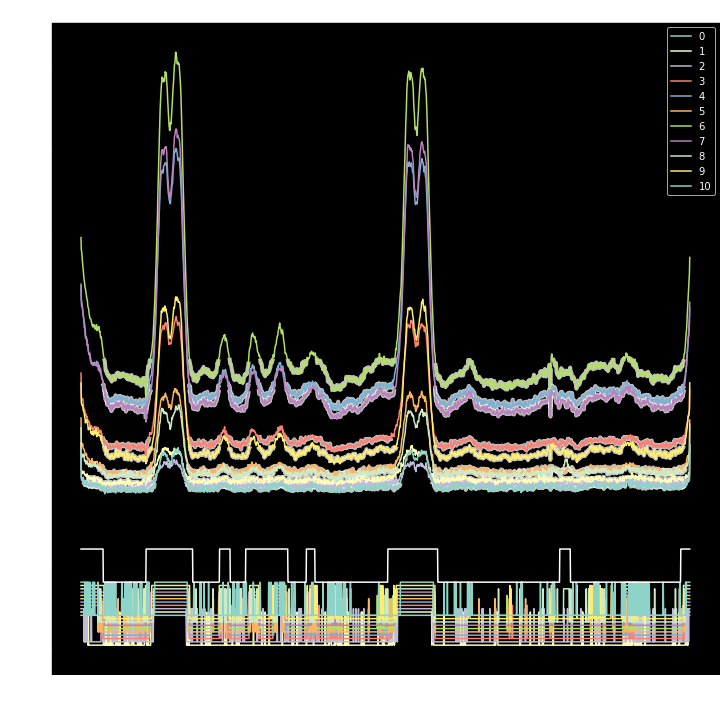

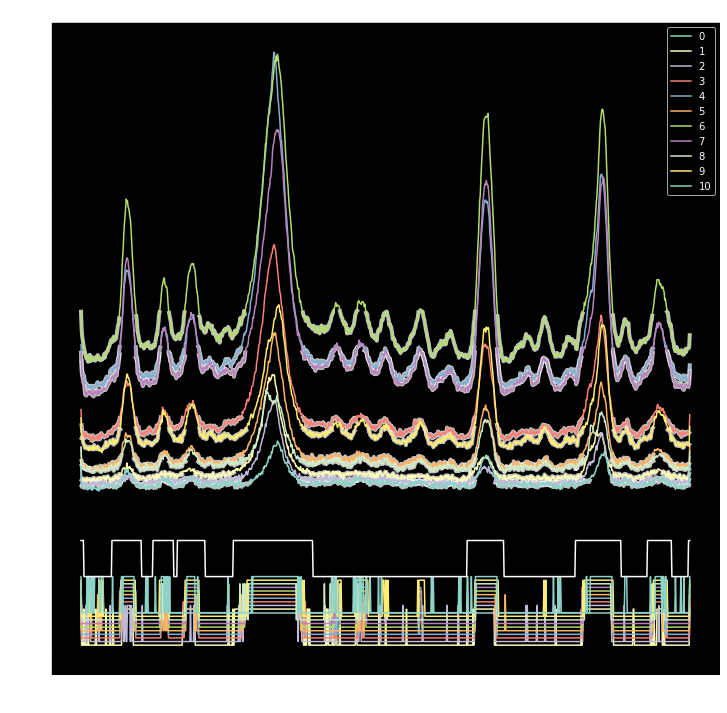

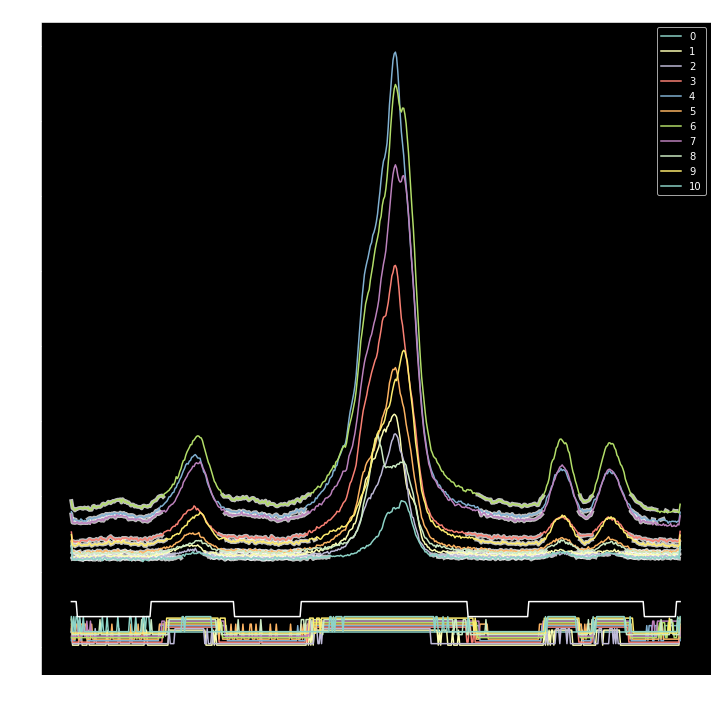

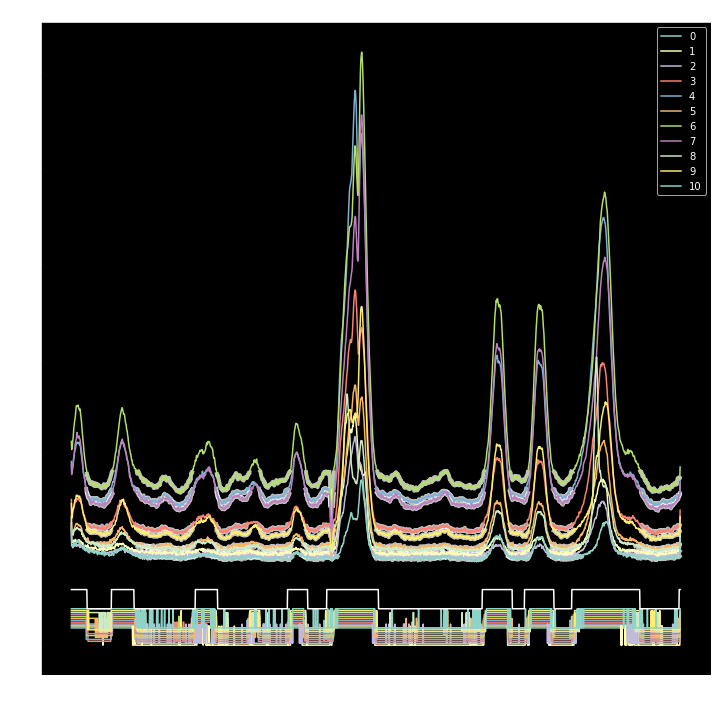

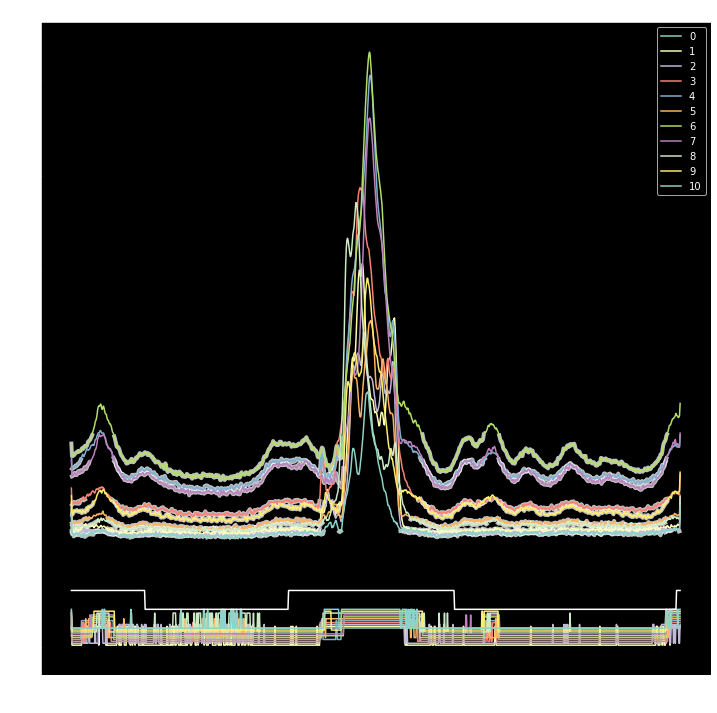

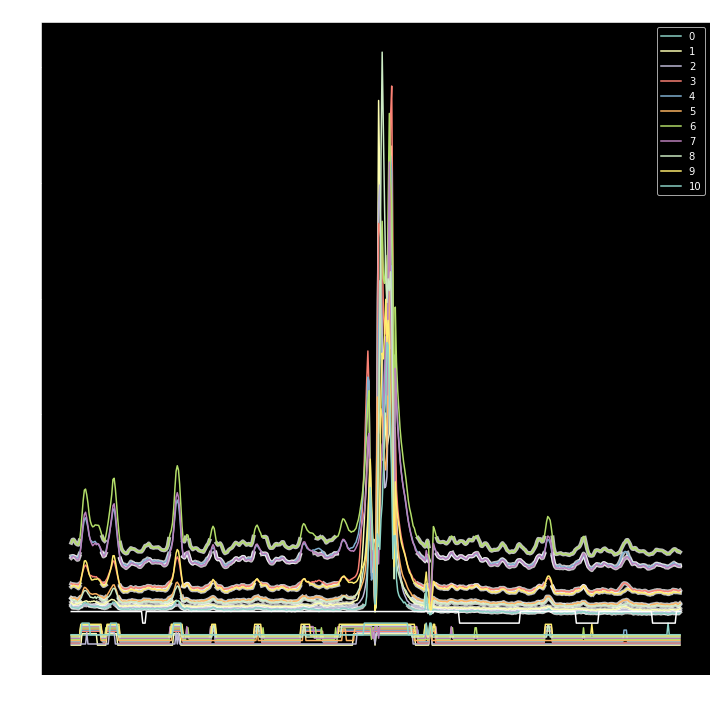

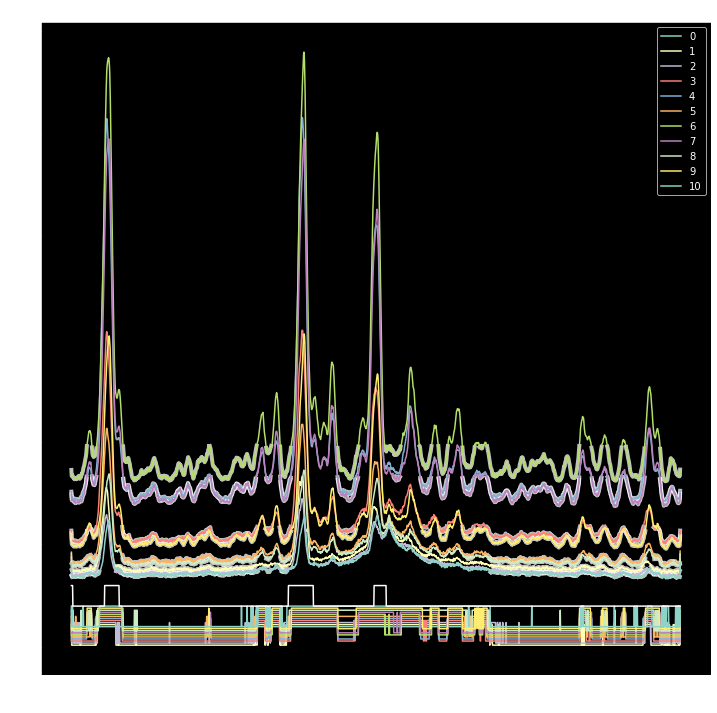

In [14]:
for spw in (0,1,2,3,4,5,6,):
    msname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibrated/uid___A002_Xcc10e0_X6dd3_W51-E_B6_spw{spw}.split')

    ms.open(msname)

    freqs = ms.cvelfreqs(spwids=0, outframe='LSRK')*u.Hz
    
    pl.figure(figsize=(12,12))
    pl.title(f"spw{spw}")
    for field in range(len(fields)):
        ms.selectinit(reset=True)
        ms.select(items={'field_id':field})
        dat = ms.getdata(['model_data', 'data', 'flag', 'corrected_data', 'time', 'antenna1', 'antenna2', 'axis_info', 'uvdist', 'weight', 'scan_number'])

        toplot = np.abs(dat['data'])
        toplot[dat['flag']] = np.nan
        meanspec = np.nanmean(toplot, axis=(0,2))

        assert freqs.size == meanspec.size
        
        L,=pl.plot(freqs, meanspec, label=str(field))
        contspec = findcont(meanspec)
        pl.plot(freqs, contspec, color='w', zorder=-5, linewidth=4, alpha=0.75)
        pl.plot(freqs, contspec.mask+0.1*field, color=L.get_color())
        
        contdatname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibration/cont.dat')
        contdat = parse_contdotdat(contdatname)

    sel = np.zeros(freqs.size, dtype='int')
    for freqrange in contdat.split(";"):
        low,high = freqrange.split("~")
        high = u.Quantity(high)
        low = u.Quantity(low, unit=high.unit)
        assert high > low
        sel += (freqs > low) & (freqs < high)
        #print(f"{field}_{spw}: {low}-{high} count={sel.sum()}")
    sel = ~(sel.astype('bool'))
    pl.plot(freqs, (sel > 0)+2, color='w')
    #ylims = pl.gca().get_ylim()
    #pl.fill_between(np.arange(len(contspec)), ylims[0], ylims[1]*sel, zorder=-10, color='w', alpha=0.5)

    pl.legend(loc='best')
    pl.xlabel("Frequency")
    pl.ylabel("Amplitude")

## Above: 7m-only per-pointing vs global (Todd's findcont) continuum ID

Overall, it looks like the findcont approach worked fine, though there are some subtleties that could be argued about.

This is what Todd's fincont looks like:

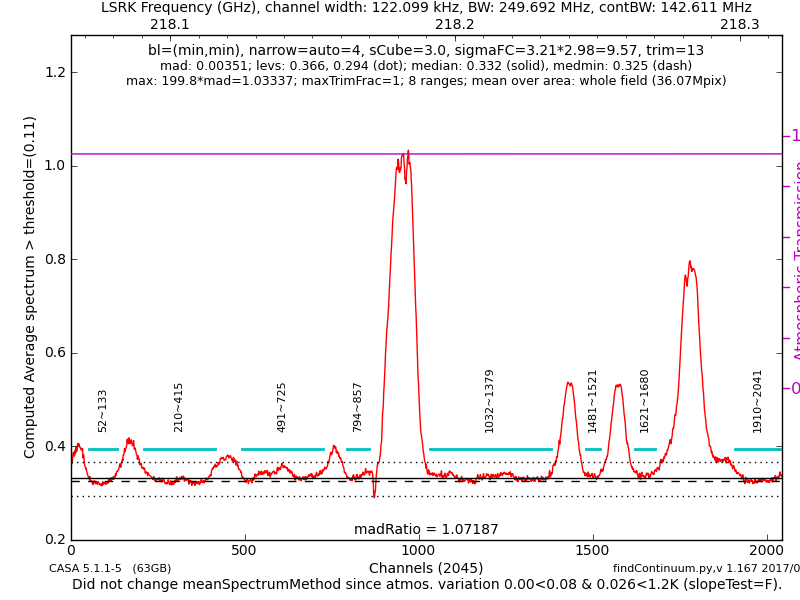

In [16]:
from IPython.display import Image, display

Image("http://www.aoc.nrao.edu/~aginsbur/alma-imf-weblogs/humanreadable/W51-E_a_06_7M/html/stage26/uid___A001_X1296_X217.s26_0.W51-E_sci.spw22.mfs.I.findcont.residual.meanSpectrum.meanAboveThreshold.min.min.3.2sigma.narrowauto=4.trim13.png")

# Now look at 12M data

first, load an example findcont selection (for debugging)

218.071524587 GHz 218.081536681 GHz 82   :   1913 1995
218.090816184 GHz 218.115968519 GHz 206   :   1631 1837
218.125125923 GHz 218.153819121 GHz 235   :   1321 1556
218.162121833 GHz 218.169936151 GHz 64   :   1189 1253
218.191181328 GHz 218.23367168 GHz 349   :   666 1015
218.246003651 GHz 218.251009698 GHz 41   :   524 565
218.263097471 GHz 218.270423394 GHz 60   :   365 425
218.298383999 GHz 218.31450103 GHz 132   :   4 136


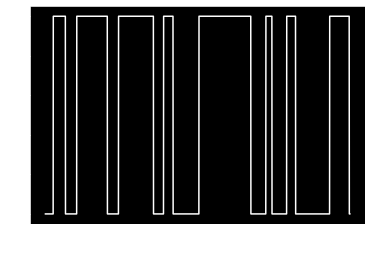

In [19]:
spw = 3
msname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibrated/uid___A002_Xcc10e0_X6dd3_W51-E_B6_spw{spw}.split')

ms.open(msname)
freqs = ms.cvelfreqs(spwids=0, outframe='LSRK')*u.Hz
ms.close()


sel = np.zeros(freqs.size, dtype='int')
for freqrange in contdat.split(";"):
    low,high = freqrange.split("~")
    high = u.Quantity(high)
    low = u.Quantity(low, unit=high.unit)
    assert high > low
    thisreg = (freqs > low) & (freqs < high)
    if any(thisreg):
        print(low, high, thisreg.sum(),"  :  ", np.argmax(thisreg),
              len(thisreg)-np.argmax(thisreg[::-1]))
    sel += thisreg
    #print(f"{field}_{spw}: {low}-{high} count={sel.sum()}")
pl.plot(freqs, (sel > 0)+2, color='w')

./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibrated/uid___A002_Xcc10e0_X6dd3_W51-E_B6_spw3.split ./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibration/cont.dat


/orange/adamginsburg/miniconda3/envs/casa6_py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


Text(0, 0.5, 'Amplitude')

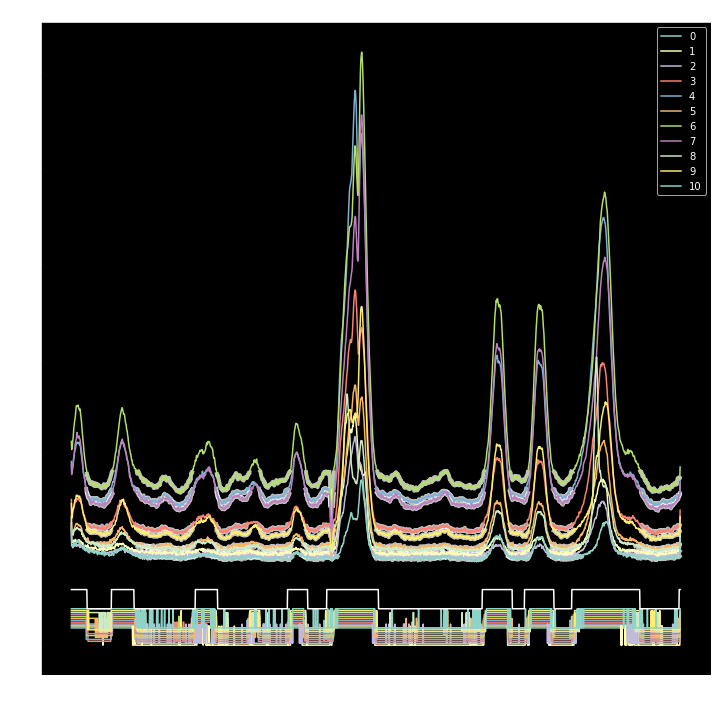

In [20]:
spw = 3
msname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibrated/uid___A002_Xcc10e0_X6dd3_W51-E_B6_spw{spw}.split')

ms.open(msname)
freqs = ms.cvelfreqs(spwids=0, outframe='LSRK')*u.Hz

#contdatname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibration/cont.dat')
contdatname = os.path.split(os.path.split(msname)[0])[0] + "/calibration/cont.dat"
print(msname, contdatname)
contdat = parse_contdotdat(contdatname)


pl.figure(figsize=(12,12))
pl.title(f"spw{spw}")
for field in range(len(fields)):
    ms.selectinit(reset=True)
    ms.select(items={'field_id':field})
    dat = ms.getdata(['model_data', 'data', 'flag', 'corrected_data', 'time', 'antenna1', 'antenna2', 'axis_info', 'uvdist', 'weight', 'scan_number'])

    toplot = np.abs(dat['data'])
    toplot[dat['flag']] = np.nan
    meanspec = np.nanmean(toplot, axis=(0,2))

    assert freqs.size == meanspec.size

    L,=pl.plot(freqs, meanspec, label=str(field))
    contspec = findcont(meanspec)
    pl.plot(freqs, contspec, color='w', zorder=-5, linewidth=4, alpha=0.75)
    pl.plot(freqs, contspec.mask+0.1*field, color=L.get_color())


sel = np.zeros(freqs.size, dtype='int')
for freqrange in contdat.split(";"):
    low,high = freqrange.split("~")
    high = u.Quantity(high)
    low = u.Quantity(low, unit=high.unit)
    assert high > low
    sel += (freqs > low) & (freqs < high)
    #print(f"{field}_{spw}: {low}-{high} count={sel.sum()}")
sel = ~(sel.astype('bool'))
pl.plot(freqs, (sel > 0)+2, color='w')
#ylims = pl.gca().get_ylim()
#pl.fill_between(np.arange(len(contspec)), ylims[0], ylims[1]*sel, zorder=-10, color='w', alpha=0.5)

pl.legend(loc='best')
pl.xlabel("Frequency")
pl.ylabel("Amplitude")

The above figure compares the 'findcont' pipeline-selected continuum (white, top "row") to the per-pointing selected continuum below.  In this case, they're close enough that I wouldn't consider re-selecting the continuum

[(slice(470, 516, None),), (slice(913, 958, None),), (slice(1453, 1497, None),), (slice(1724, 1782, None),), (slice(1912, 1920, None),)]


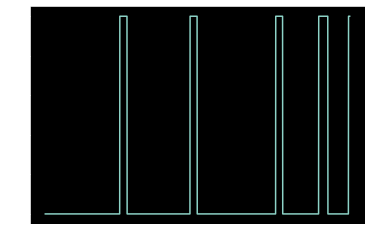

In [35]:
# use scipy for region selection
from scipy.ndimage import find_objects, label
objs = find_objects(label(sel.astype('int'))[0])
pl.plot(sel.astype('int'))
print(objs)

# Do the same test for a TM session

Skipped field 0
Skipped field 0
Skipped field 0
Skipped field 0
Skipped field 0
Skipped field 0
Skipped field 0
Skipped field 0


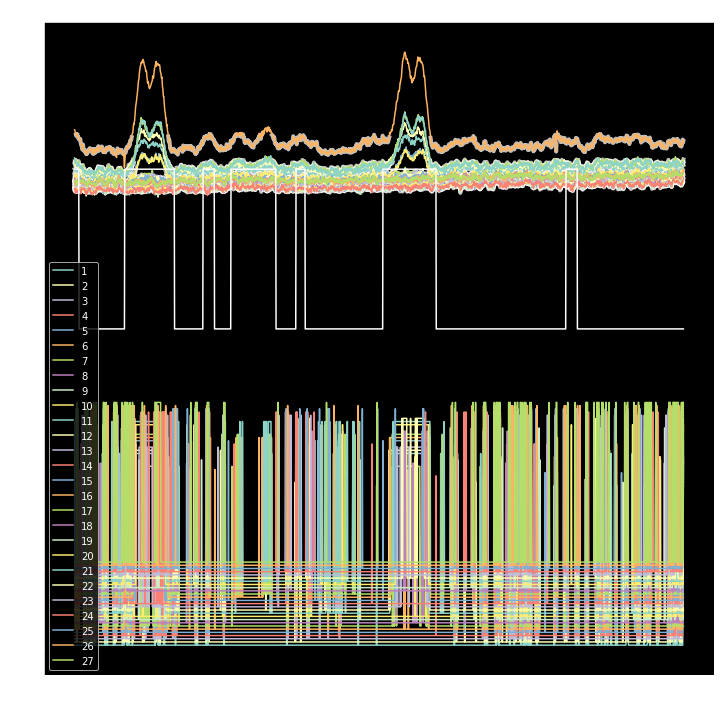

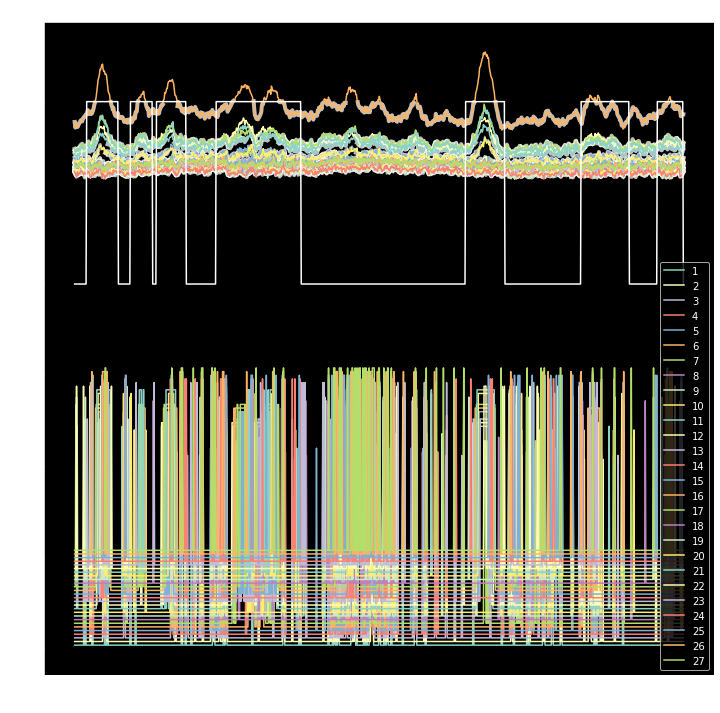

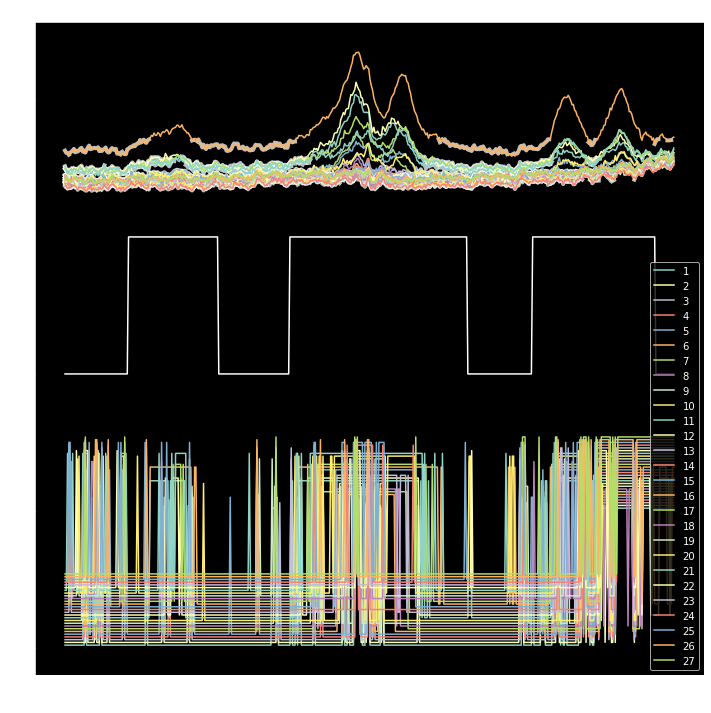

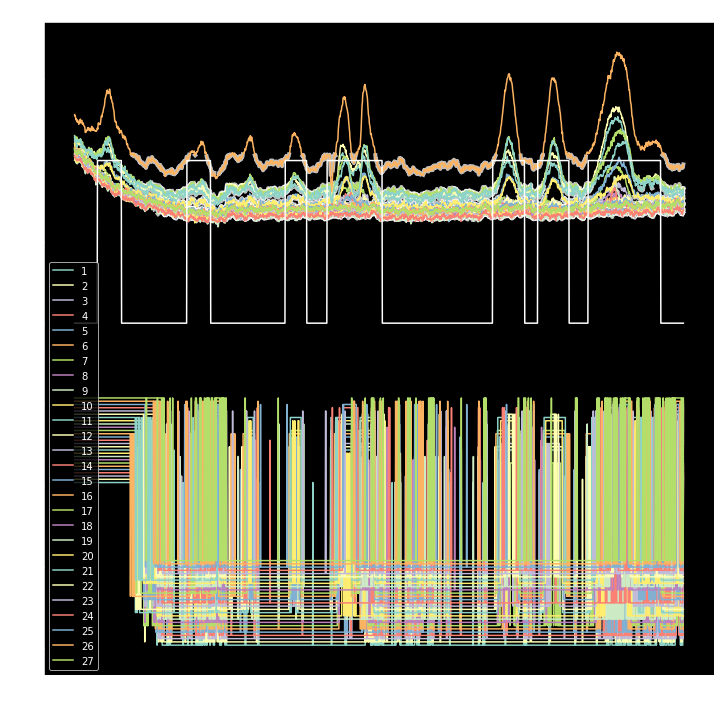

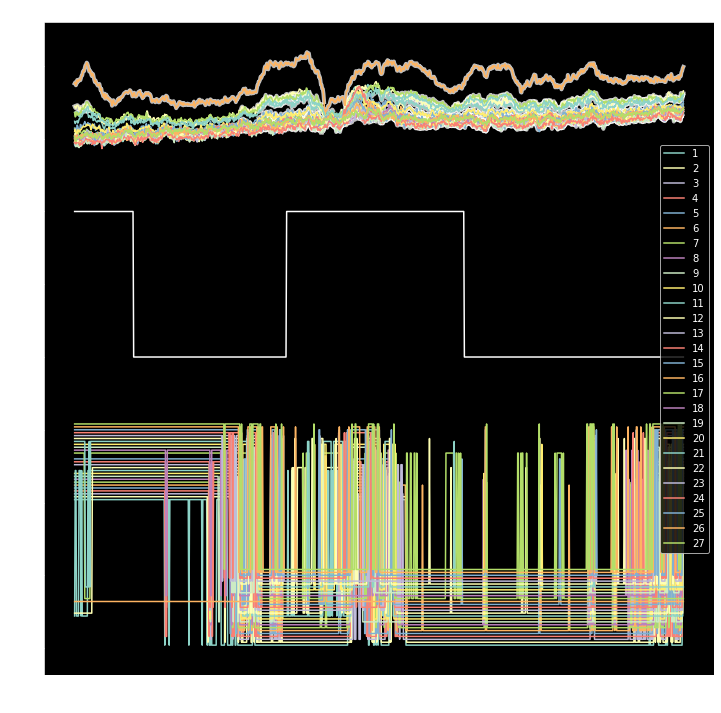

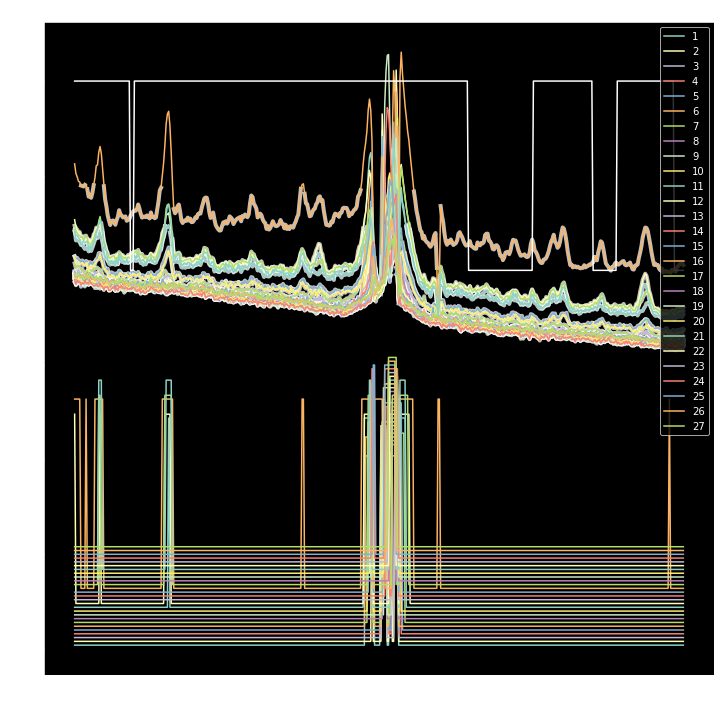

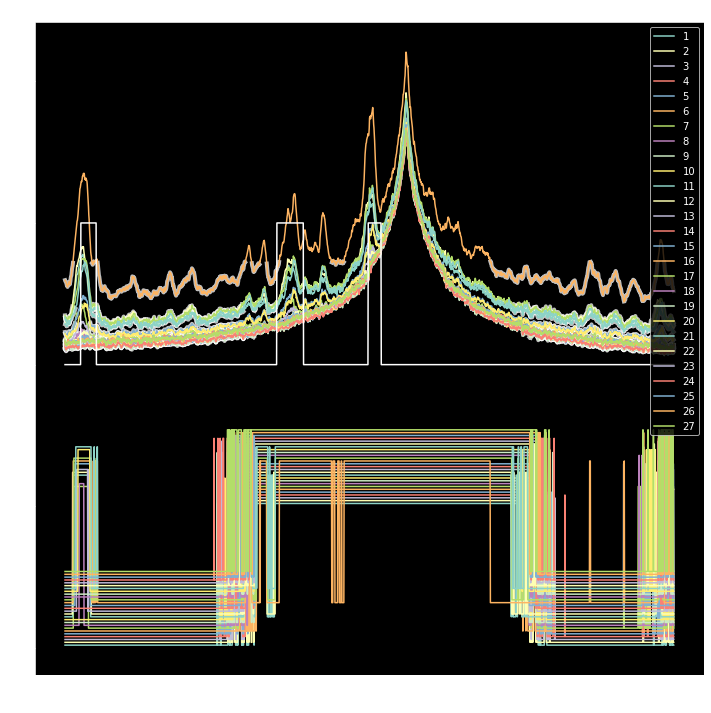

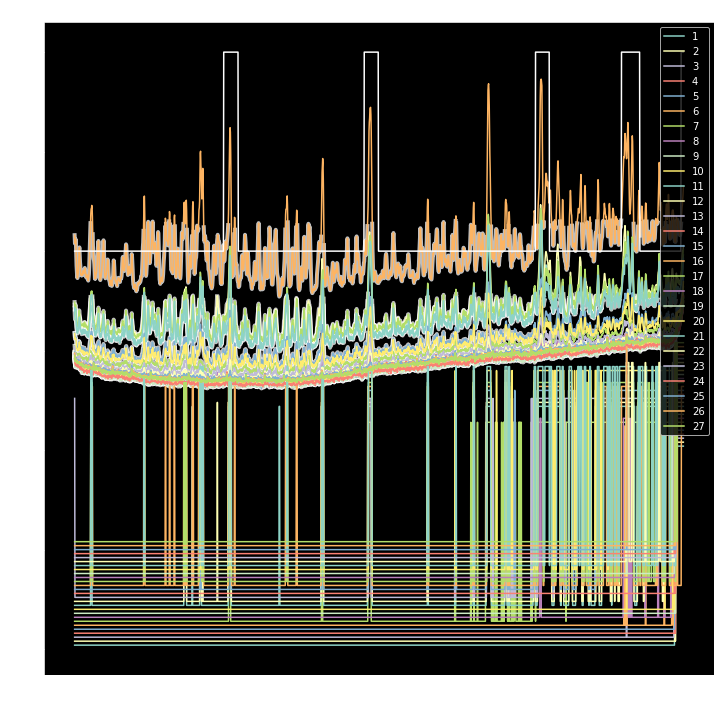

In [29]:
for spw in (0,1,2,3,4,5,6,7):
    msname = ('./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X213/'
              '/calibrated/'
              f'uid___A002_Xc96463_X6519_W51-E_B6_spw{spw}.split')

    msmd.open(msname)
    fields = msmd.fieldnames()
    msmd.close()

    
    ms.open(msname)

    freqs = ms.cvelfreqs(spwids=0, outframe='LSRK')*u.Hz
    
    pl.figure(figsize=(12,12))
    pl.title(f"spw{spw}")
    for field in range(len(fields)):
        assert ms.selectinit(reset=True)
        OK = ms.select(items={'field_id':field})
        if not OK:# or 'data' not in dat:
            print(f"Skipped field {field}")
            continue
        dat = ms.getdata(['model_data', 'data', 'flag', 'corrected_data', 'time', 'antenna1', 'antenna2', 'axis_info', 'uvdist', 'weight', 'scan_number'])
        
        
        toplot = np.abs(dat['data'])
        toplot[dat['flag']] = np.nan
        meanspec = np.nanmean(toplot, axis=(0,2))

        assert freqs.size == meanspec.size
        
        L,=pl.plot(freqs, meanspec, label=str(field))
        contspec = findcont(meanspec)
        pl.plot(freqs, contspec, color='w', zorder=-5, linewidth=4, alpha=0.75)
        pl.plot(freqs, contspec.mask+0.02*field, color=L.get_color())
        
        contdatname = (f'./science_goal.uid___A001_X1296_X211/group.uid___A001_X1296_X212/member.uid___A001_X1296_X217/calibration/cont.dat')
        contdat = parse_contdotdat(contdatname)

    sel = np.zeros(freqs.size, dtype='int')
    for freqrange in contdat.split(";"):
        low,high = freqrange.split("~")
        high = u.Quantity(high)
        low = u.Quantity(low, unit=high.unit)
        assert high > low
        sel += (freqs > low) & (freqs < high)
        #print(f"{field}_{spw}: {low}-{high} count={sel.sum()}")
    sel = ~(sel.astype('bool'))
    pl.plot(freqs, (sel > 0)+2, color='w')
    #ylims = pl.gca().get_ylim()
    #pl.fill_between(np.arange(len(contspec)), ylims[0], ylims[1]*sel, zorder=-10, color='w', alpha=0.5)

    pl.legend(loc='best')
    pl.xlabel("Frequency")
    pl.ylabel("Amplitude")
    pl.savefig(f"contselection_spw{spw}.png")

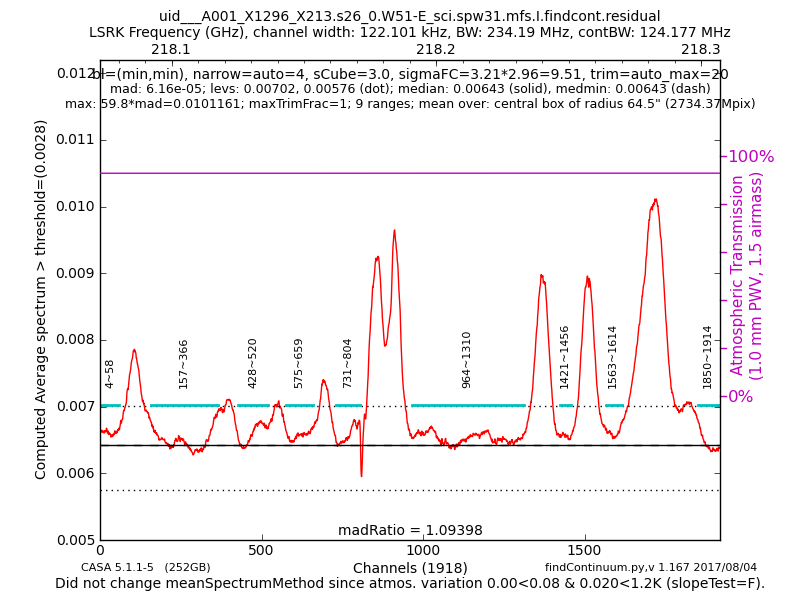

In [30]:
from IPython.display import Image, display

Image("http://www.aoc.nrao.edu/~aginsbur/alma-imf-weblogs/humanreadable/W51-E_a_06_TM1/html/stage26/uid___A001_X1296_X213.s26_0.W51-E_sci.spw31.mfs.I.findcont.residual.meanSpectrum.meanAboveThreshold.min.min.3.2sigma.narrowauto=4.trimauto_max=20.png")

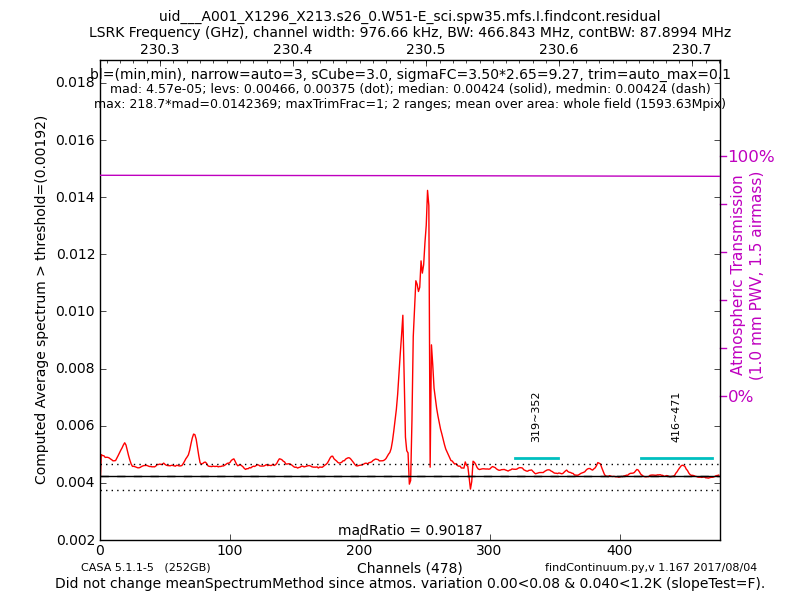

In [33]:
from IPython.display import Image, display

Image("http://www.aoc.nrao.edu/~aginsbur/alma-imf-weblogs/humanreadable/W51-E_a_06_TM1/html/stage26/uid___A001_X1296_X213.s26_0.W51-E_sci.spw35.mfs.I.findcont.residual.meanSpectrum.meanAboveThreshold.min.min.3.5sigma.narrowauto=3.trimauto_max=0.1.png")

Findcont is arguably too aggressive for spw 0, 1, 2

spw3 is very problematic: something horrendous is happening on the left side of the spectrum

the slope in spw5 is very worrying - such a steep slope is unphysical?  And it's going the wrong direction?  And findcont flagged out everything!

spw6 shows where findcont wins:  that spectral feature almost certainly doesn't exist in the image data

spw7 is another win for findcont